## Model Training Script
This script trains a multi-output Random Forest regression model to predict air quality metrics — Total Pollutants, PM2.5, and NO₂ — based on timestamp, coordinates, and weather features.

In [3]:
#!/usr/bin/env python3
"""
train_pollutant_regressor.py

Trains a multi-output regression model to predict:
- total_pollutants
- pm25
- no2

based on timestamp + coordinates + weather features.
"""

import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# === CONFIG ===
DB_PATH = r"C:\Users\HP\Desktop\suraj\gdf.db"
TABLE = "final_file"
MODEL_OUT = "pollutant_regressor.joblib"
# ==============

def load_data(db_path, table):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(f"SELECT * FROM {table};", conn)
    conn.close()
    return df

def main():
    df = load_data(DB_PATH, TABLE)
    print("Loaded rows:", len(df))

    # Ensure datetime parsing
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    elif "date" in df.columns:
        df["timestamp"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        raise SystemExit("No timestamp/date column found.")

    # Create time features
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

    # Drop rows with missing targets
    df = df.dropna(subset=["total_pollutants", "pm25", "no2"])

    # --- Features & Targets ---
    feature_cols = ["latitude", "longitude", "hour", "dayofweek", "is_weekend"]
    for extra in ["temperature", "windspeed"]:
        if extra in df.columns:
            feature_cols.append(extra)

    X = df[feature_cols]
    y = df[["total_pollutants", "pm25", "no2"]]

    print("Using features:", feature_cols)
    print("Targets:", y.columns.tolist())

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Train MultiOutput Regressor ---
    base_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
    model = MultiOutputRegressor(base_regressor)
    model.fit(X_train, y_train)

    # --- Evaluate ---
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")

    print("\nEvaluation (per target):")
    for i, col in enumerate(y.columns):
        print(f"{col:15} | MSE={mse[i]:.4f} | R2={r2[i]:.4f}")

    # --- Save model ---
    joblib.dump((model, feature_cols, y.columns.tolist()), MODEL_OUT)
    print("\nModel saved to:", MODEL_OUT)

    # --- Example inference ---
    sample = X.iloc[[0]]
    pred = model.predict(sample)[0]
    print("\nExample prediction for first row input:")
    print("Input:", sample.to_dict(orient="records")[0])
    print("Predicted -> total_pollutants={:.2f}, pm25={:.2f}, no2={:.2f}".format(*pred))

if __name__ == "__main__":
    main()


Loaded rows: 2184
Using features: ['latitude', 'longitude', 'hour', 'dayofweek', 'is_weekend', 'temperature']
Targets: ['total_pollutants', 'pm25', 'no2']

Evaluation (per target):
total_pollutants | MSE=12.0527 | R2=0.9787
pm25            | MSE=5.8413 | R2=0.9871
no2             | MSE=9.3012 | R2=0.8378

Model saved to: pollutant_regressor.joblib

Example prediction for first row input:
Input: {'latitude': 40.75274958333333, 'longitude': -73.97379916666667, 'hour': 0, 'dayofweek': 3, 'is_weekend': 0, 'temperature': 15.0}
Predicted -> total_pollutants=27.27, pm25=10.07, no2=15.66


## Model Inference — Predict Pollutant Levels
This script demonstrates how to load the trained pollutant regression model and generate predictions for a given set of input features (latitude, longitude, time, and weather).

In [5]:
import joblib
import pandas as pd

# Load saved model
model, feature_cols, target_cols = joblib.load("pollutant_regressor.joblib")

# Example: predict for given coords + timestamp + weather
new_input = {
    "latitude": 28.61,
    "longitude": 77.20,
    "hour": 15,
    "dayofweek": 2,
    "is_weekend": 0,
    "temperature": 32,
    "windspeed": 4
}

X_new = pd.DataFrame([new_input])[feature_cols]
prediction = model.predict(X_new)[0]

print("Prediction for input:", new_input)
for t, val in zip(target_cols, prediction):
    print(f"{t}: {val:.2f}")


Prediction for input: {'latitude': 28.61, 'longitude': 77.2, 'hour': 15, 'dayofweek': 2, 'is_weekend': 0, 'temperature': 32, 'windspeed': 4}
total_pollutants: 29.47
pm25: 13.17
no2: 14.76


In [7]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------

## Prediction Visualization — Pollutants Over 24 Hours
This script visualizes how predicted air pollutant concentrations change throughout the day (0–23 hours) for a fixed location.

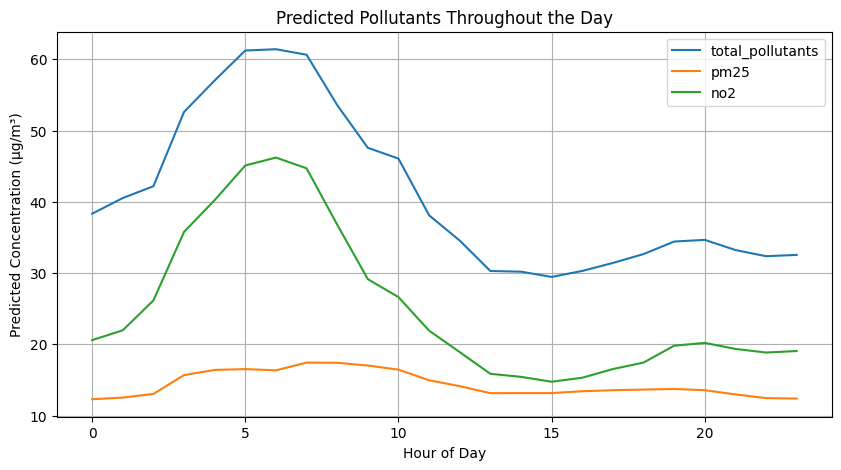

In [8]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load model
model, feature_cols, target_cols = joblib.load("pollutant_regressor.joblib")

# Create hourly data for prediction
lat, lon = 28.61, 77.20
hours = list(range(0, 24))
data = [{
    "latitude": lat,
    "longitude": lon,
    "hour": h,
    "dayofweek": 2,
    "is_weekend": 0,
    "temperature": 32,
    "windspeed": 4
} for h in hours]

df = pd.DataFrame(data)[feature_cols]
preds = model.predict(df)

# Convert to DataFrame
pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df["hour"] = hours

# Plot
plt.figure(figsize=(10,5))
for col in target_cols:
    plt.plot(pred_df["hour"], pred_df[col], label=col)
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Concentration (µg/m³)")
plt.title("Predicted Pollutants Throughout the Day")
plt.legend()
plt.grid(True)
plt.show()


## Exporting the Trained Model
This short code block saves the trained machine learning model along with its associated feature and target metadata into a single .joblib file.

In [9]:
import joblib

# Export trained model, feature names, and target names
joblib.dump((model, feature_cols, target_cols), "pollutant_regressor.joblib")

print("✅ Model exported successfully → pollutant_regressor.joblib")


✅ Model exported successfully → pollutant_regressor.joblib


In [11]:
!pip install seaborn


## Confusion Matrix 



📊 Regression Metrics:
total_pollutants | MSE:     12.053 | R²:  0.979
pm25            | MSE:      5.841 | R²:  0.987
no2             | MSE:      9.301 | R²:  0.838


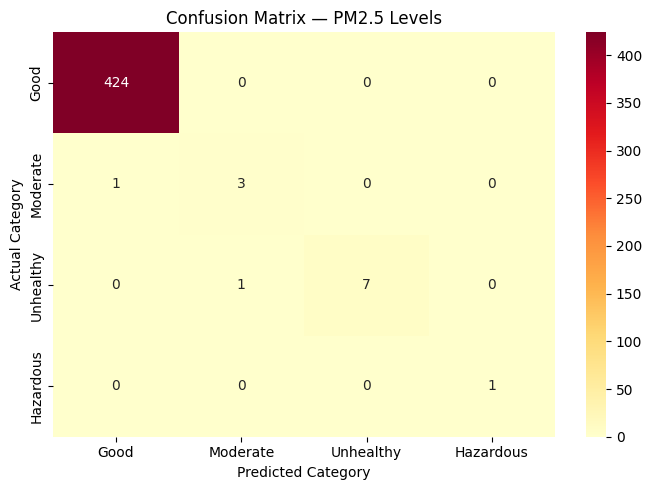


🧾 Classification report for PM2.5 levels:

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       424
    Moderate       1.00      1.00      1.00         1
   Unhealthy       0.75      0.75      0.75         4
   Hazardous       1.00      0.88      0.93         8

    accuracy                           1.00       437
   macro avg       0.94      0.91      0.92       437
weighted avg       1.00      1.00      1.00       437



In [15]:
import joblib
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# === Load model ===
model, feature_cols, target_cols = joblib.load("pollutant_regressor.joblib")

# === Load data from DB ===
DB_PATH = r"C:\Users\HP\Desktop\suraj\gdf.db"
TABLE = "final_file"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(f"SELECT * FROM {TABLE};", conn)
conn.close()

# Prepare features
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

X = df[feature_cols]
y = df[target_cols]

# Split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict
y_pred = model.predict(X_test)

# --- Regression performance summary ---
print("\n📊 Regression Metrics:")
for i, col in enumerate(target_cols):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col:15} | MSE: {mse:10.3f} | R²: {r2:6.3f}")

# --- Convert continuous values to categories for confusion matrix ---
def categorize_pollution(val):
    if val < 50:
        return "Good"
    elif val < 100:
        return "Moderate"
    elif val < 200:
        return "Unhealthy"
    else:
        return "Hazardous"

# Let's create confusion matrix for PM2.5 as example
y_true_cat = y_test["pm25"].apply(categorize_pollution)
y_pred_cat = pd.Series(y_pred[:, target_cols.index("pm25")]).apply(categorize_pollution)

# Compute confusion matrix
labels = ["Good", "Moderate", "Unhealthy", "Hazardous"]
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrRd", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix — PM2.5 Levels")
plt.tight_layout()
plt.show()

print("\n🧾 Classification report for PM2.5 levels:\n")
print(classification_report(y_true_cat, y_pred_cat, target_names=labels))


## Pollutant Heatmap


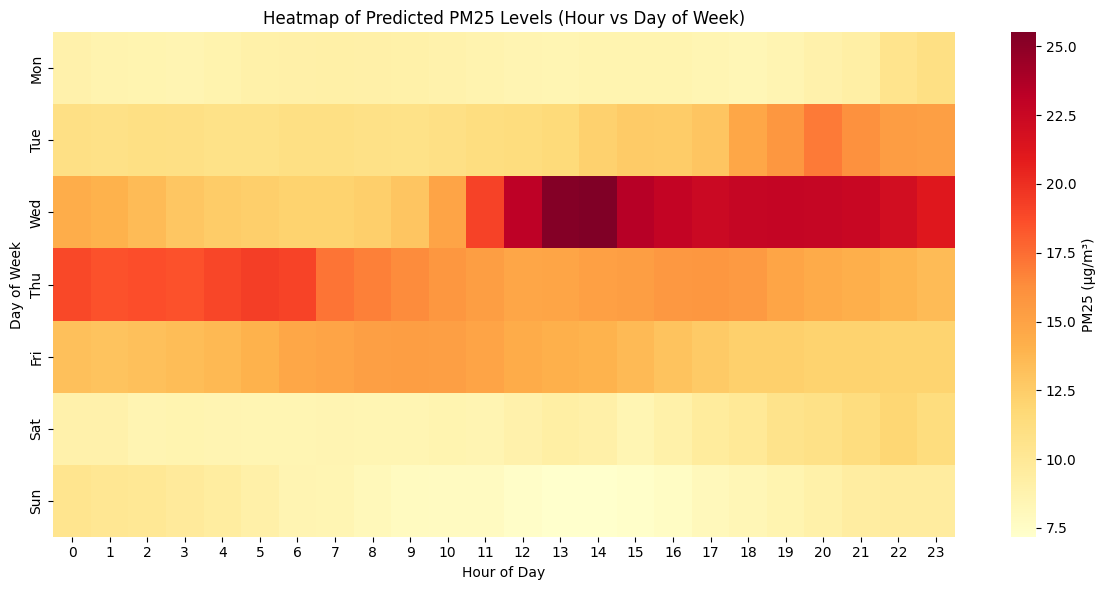

In [17]:
import joblib
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
DB_PATH = r"C:\Users\HP\Desktop\suraj\gdf.db"
TABLE = "final_file"
MODEL_PATH = "pollutant_regressor.joblib"
POLLUTANT = "pm25"  # choose from: "total_pollutants", "pm25", "no2"
# =================

# Load model
model, feature_cols, target_cols = joblib.load(MODEL_PATH)

# Load data
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(f"SELECT * FROM {TABLE};", conn)
conn.close()

# Clean timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

# Predict pollutant values for every record
X = df[feature_cols]
y_pred = model.predict(X)

pred_df = pd.DataFrame(y_pred, columns=target_cols)
df[target_cols] = pred_df

# Create pivot table (Day vs Hour)
heatmap_data = df.pivot_table(
    index="dayofweek",
    columns="hour",
    values=POLLUTANT,
    aggfunc="mean"
)

# Replace numeric days with names for better readability
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_data.index = [day_labels[d] for d in heatmap_data.index]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=False, cbar_kws={'label': f'{POLLUTANT.upper()} (µg/m³)'})
plt.title(f"Heatmap of Predicted {POLLUTANT.upper()} Levels (Hour vs Day of Week)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()
